# Introduction
I chose the "Rain in Australia" dataset from Kaggle: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
> This dataset contains about 10 years of daily weather observations from numerous Australian weather stations.
> RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No?
>This column is Yes if the rain for that day was 1mm or more.

It has categorical and numerical features, some missing values.

## Plan


**1.Quick description of the dataset**

**2.Management of missing values**

**3.Management of skewed values and outliers**

**4.Encoding of categorical variables**

**5.Classifications**

    **5.1 Logistic Regressions**

    **5.2 Logistic Regression with regularization**
    
    **5.3 K-Nearest Neighbours**
    
    **5.4 Gradient Boosting**

**6.Conclusion**

### Imports

In [1]:
from IPython.display import display

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

from math import floor
from scipy.stats import boxcox

%matplotlib inline

### Loading file

In [2]:
raw_data = pd.read_csv('C:/Users/Syla/CourseRA/weatherAUS.csv')

### Sub-functions - 1
Some functions I will use several times in this first section

In [3]:
def check_for_nans(df):
    ''' This function will count the number of Nans in the dataframe and return a frame showing the percentage 
    per feature if there are any'''
    n_nan = (df.isna().sum())  # counting the number of Nan values
    n_nan = n_nan[n_nan > 0] # Keep only the features if there are Nan inside
    
    
    if n_nan.shape[0] > 0: # If there are Nan values, show the percentage per feature
        print('\033[1m' + 'There are NaN Values in the dataset.' + '\033[0m')
        percent_nan = n_nan / df.shape[0] * 100
        df_nan = pd.DataFrame({'feature': n_nan.index, 
                               'number_nan': n_nan.values, 
                               'percent_nan':percent_nan.values})
        
        return df_nan.sort_values(by='percent_nan', ascending = False)
        
    else: # If there are no Nan values, simply say it.
        print('\033[1m' + 'There are no NaN values in the dataset.' + '\033[0m')
    
        return


def describe_all(df):
    ''' This function simply concatenates many standard tools for the description of the dataframe. 
    '''
    
    print('\033[1m' + 'Data dimensions (row, col) : ' + '\033[0m' + str(df.shape))
    print("\n")
    
    print('\033[1m' + 'Header:' + '\033[0m')
    display(df.head())   
    print("\n")
    
    print('\033[1m' + 'Data dtypes:' + '\033[0m')
    display(df.dtypes)
    print("\n")
    
    print('\033[1m' + 'Description:' + '\033[0m')
    display(df.describe().T)
    print("\n")
    
    print('\033[1m' + 'Column names: ' + '\033[0m' + str(df.columns.tolist()))
    print("\n")
    
    return

def count_unique_strings(df):
    '''This function will check if there are some objects features, and count their numbers of uniques'''
    mask = df.dtypes == "object"
    str_cols = df.columns[mask]
    
        
    if str_cols.shape[0] > 0: 
        print('\033[1m' + 'There are object features in the dataset.' + '\033[0m')
        
        df_str = pd.DataFrame()
        
        for i, col in enumerate(str_cols):
            df_str2 = pd.DataFrame({'feature': col, 
                                    'n_uniques': df[col].nunique(),
                                    'unique_list':np.array2string(df[col].unique())}, 
                                   index = [i])
            df_str = df_str.append(df_str2)
            
            
        return df_str
        
        
    else: # If there are no object features, simply say it.
        print('\033[1m' + 'There are no object features in the dataset.' + '\033[0m')
    
        return

## 1.Quick description of the dataset
First, let's have a broad look at the dataset:

In [4]:
describe_all(raw_data)

Data dimensions (row, col) : (145460, 23)


Header:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No




Data dtypes:


Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object



Description:


,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0




Column names: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']




The dataset is constituted of string and float values, column names are informative enough as so.



## 2.Management of NaN values

Let's have a look for NaNs values:

In [5]:
check_for_nans(raw_data)

There are NaN Values in the dataset.


,feature,number_nan,percent_nan
4,Sunshine,69835,48.009762
3,Evaporation,62790,43.166506
16,Cloud3pm,59358,40.807095
15,Cloud9am,55888,38.421559
13,Pressure9am,15065,10.356799
14,Pressure3pm,15028,10.331363
7,WindDir9am,10566,7.263853
5,WindGustDir,10326,7.098859
6,WindGustSpeed,10263,7.055548
12,Humidity3pm,4507,3.098446


4 features have 40% or more NaNs, that might be an issue. Let's visualize it with missingno:

<AxesSubplot:>

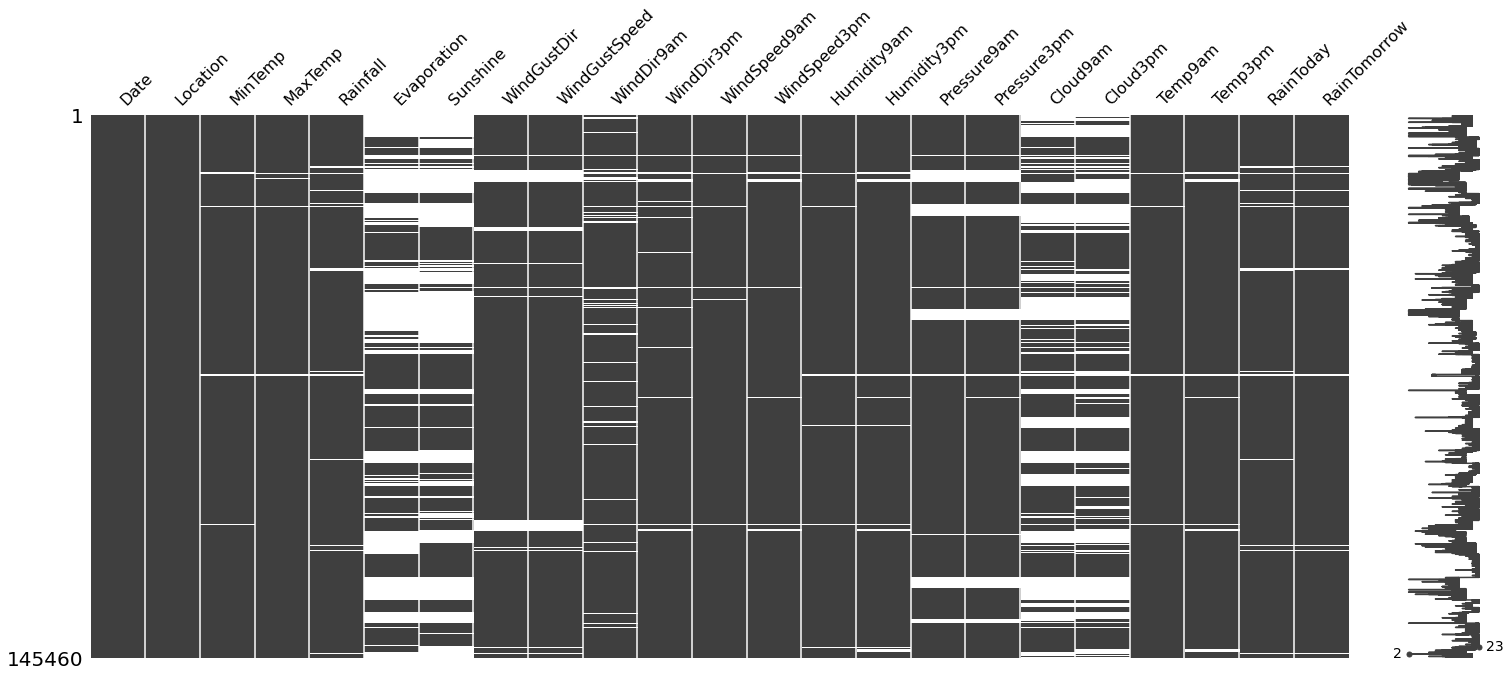

In [6]:
msno.matrix(raw_data)

The columns Evaporation, Sunshine, Cloud9am and Cloud3pm have too many missing values, removing the NaNs would remove a lot of data. I think we have to drop those columns:

In [7]:
data = raw_data.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis = 1).copy(deep=True)

Let's check again:

<AxesSubplot:>

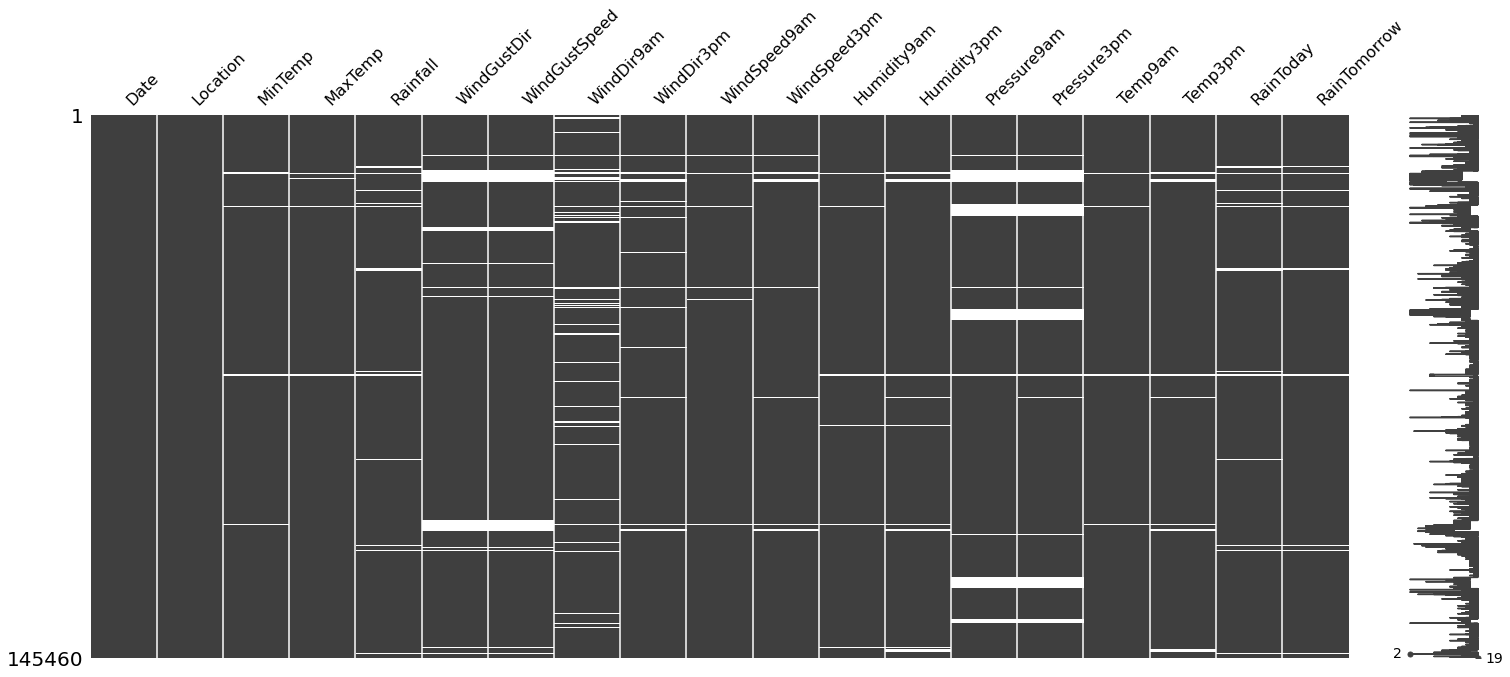

In [8]:
msno.matrix(data)

It is better, still many NaNs left. We can try to interpolate the values, but first we have to sort the observations by
date. Let's have a look at the strings features:

In [9]:
count_unique_strings(raw_data)

There are object features in the dataset.


,feature,n_uniques,unique_list
0,Date,3436,['2008-12-01' '2008-12-02' '2008-12-03' ... '2...
1,Location,49,['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbou...
2,WindGustDir,16,['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan...
3,WindDir9am,16,['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' nan ...
4,WindDir3pm,16,['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'N...
5,RainToday,2,['No' 'Yes' nan]
6,RainTomorrow,2,['No' 'Yes' nan]


There are some NaNs in RainToday and RainTomorrow, let's start by dropping them:

In [10]:
data.dropna(axis=0,subset=['RainTomorrow', 'RainToday'], inplace= True)

And convert the date column to year and day of the year:

In [11]:
data['Year'] = pd.to_datetime(data['Date']).dt.year.astype(float) 
# Conversion to float as I will use the type to select features or not.
data['DayYear'] = pd.to_datetime(data['Date']).dt.dayofyear.astype(float)
data = data.drop(['Date'], axis = 1)

In [12]:
data.head(10)

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,DayYear
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,2008.0,336.0
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,2008.0,337.0
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,2008.0,338.0
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,2008.0,339.0
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,2008.0,340.0
5,Albury,14.6,29.7,0.2,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,20.6,28.9,No,No,2008.0,341.0
6,Albury,14.3,25.0,0.0,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,18.1,24.6,No,No,2008.0,342.0
7,Albury,7.7,26.7,0.0,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,16.3,25.5,No,No,2008.0,343.0
8,Albury,9.7,31.9,0.0,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,18.3,30.2,No,Yes,2008.0,344.0
9,Albury,13.1,30.1,1.4,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,20.1,28.2,Yes,No,2008.0,345.0


We removed the Date column and created two new ones, Year & DateYear. Now we can sort the values by dates and interpolate the data:

In [13]:
data.sort_values(by = ['Location','Year','DayYear'],inplace = True)
data.interpolate(method = 'nearest', inplace = True)

<AxesSubplot:>

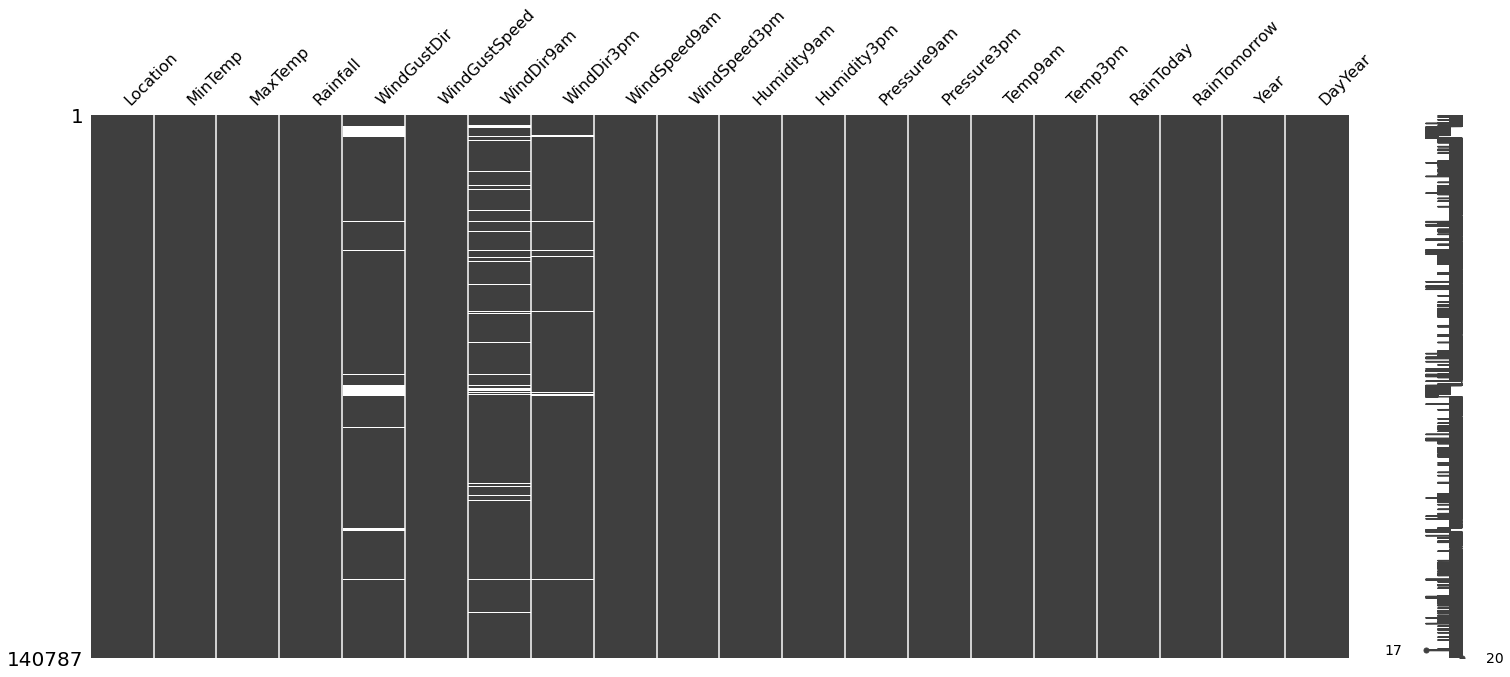

In [14]:
msno.matrix(data)

In [15]:
check_for_nans(data)

There are NaN Values in the dataset.


,feature,number_nan,percent_nan
1,WindDir9am,9660,6.861429
0,WindGustDir,9163,6.508413
2,WindDir3pm,3670,2.606775


Really few NaNs left, we can simply remove them.

In [16]:
data.dropna(axis=0,how="any",inplace= True)
data.reset_index(drop = True, inplace = True)

This should be enough for NaNs management, let's check a last time and copy the data to a clean array:

In [17]:
check_for_nans(data)

There are no NaN values in the dataset.


In [18]:
clean_data = data.copy(deep=True)

Now, we should encode the locations to their corresponding latitude & longitude. This should be much more powerful than a simple label-encoding, as we can expect that if it rains somewhere, there is a high possibility that it rains nearby as well.

In [19]:
# Got the list of cities from the internet.
locations = pd.read_csv('C:/Users/Syla/CourseRA/worldcities.csv')

In [20]:
# Keeping only Australia
locations = locations[locations['country'] =='Australia']
locations.head(10)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
129,Sydney,Sydney,-33.8650,151.2094,Australia,AU,AUS,New South Wales,admin,5312163.0,1036074917
141,Melbourne,Melbourne,-37.8136,144.9631,Australia,AU,AUS,Victoria,admin,5078193.0,1036533631
312,Brisbane,Brisbane,-27.4678,153.0281,Australia,AU,AUS,Queensland,admin,2514184.0,1036192929
378,Perth,Perth,-31.9522,115.8589,Australia,AU,AUS,Western Australia,admin,2059484.0,1036178956
538,Adelaide,Adelaide,-34.9289,138.6011,Australia,AU,AUS,South Australia,admin,1345777.0,1036538171
754,Canberra,Canberra,-35.2931,149.1269,Australia,AU,AUS,Australian Capital Territory,primary,426704.0,1036142029
1087,Gold Coast,Gold Coast,-28.0167,153.4000,Australia,AU,AUS,Queensland,NaN,679127.0,1036153217
1903,Newcastle,Newcastle,-32.9167,151.7500,Australia,AU,AUS,New South Wales,NaN,322278.0,1036468001
1995,Wollongong,Wollongong,-34.4331,150.8831,Australia,AU,AUS,New South Wales,NaN,302739.0,1036502269
2205,Geelong,Geelong,-38.1500,144.3500,Australia,AU,AUS,Victoria,NaN,263280.0,1036870987


In [21]:
# And keeping only the columns I am interested in.
columns_to_keep = ['city_ascii', 'lat', 'lng']
locations_short = locations[columns_to_keep]
locations_short.columns = ['Location', 'Lat','Long']
locations_short.reset_index()

,index,Location,Lat,Long
0,129,Sydney,-33.8650,151.2094
1,141,Melbourne,-37.8136,144.9631
2,312,Brisbane,-27.4678,153.0281
3,378,Perth,-31.9522,115.8589
4,538,Adelaide,-34.9289,138.6011
...,...,...,...,...
356,26264,Bullsbrook,-31.6630,116.0300
357,26300,McMinns Lagoon,-12.5329,131.0500
358,26369,Ceduna,-32.1167,133.6667
359,26450,Quilpie,-26.6161,144.2675


In [22]:
locations_short.head(10)

,Location,Lat,Long
129,Sydney,-33.8650,151.2094
141,Melbourne,-37.8136,144.9631
312,Brisbane,-27.4678,153.0281
378,Perth,-31.9522,115.8589
538,Adelaide,-34.9289,138.6011
754,Canberra,-35.2931,149.1269
1087,Gold Coast,-28.0167,153.4000
1903,Newcastle,-32.9167,151.7500
1995,Wollongong,-34.4331,150.8831
2205,Geelong,-38.1500,144.3500


We have our cities with latitude & longitude, we can merge them with the other sataset:

In [23]:
clean_data = pd.merge(data, locations_short, on='Location')

In [24]:
clean_data.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,DayYear,Lat,Long
0,Adelaide,8.8,15.7,5.0,NW,48.0,SW,W,13.0,15.0,...,1017.4,1017.7,13.5,14.9,Yes,No,2008.0,183.0,-34.9289,138.6011
1,Adelaide,12.7,15.8,0.8,SW,35.0,SSW,SW,13.0,15.0,...,1022.4,1022.6,13.7,15.5,No,No,2008.0,184.0,-34.9289,138.6011
2,Adelaide,6.2,15.1,0.0,W,20.0,NNE,SW,2.0,11.0,...,1027.8,1026.5,9.3,13.9,No,No,2008.0,185.0,-34.9289,138.6011
3,Adelaide,5.3,15.9,0.0,NNE,30.0,NNE,NE,6.0,13.0,...,1028.7,1025.6,10.2,15.3,No,No,2008.0,186.0,-34.9289,138.6011
4,Adelaide,7.6,11.2,16.2,WSW,46.0,WNW,SW,17.0,13.0,...,1015.9,1017.9,9.8,9.3,Yes,Yes,2008.0,189.0,-34.9289,138.6011


We can now drop our location column and copy the dataset to a new, complete one:

In [25]:
clean_data = clean_data.drop(['Location'], axis=1)
clean_data.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,DayYear,Lat,Long
0,8.8,15.7,5.0,NW,48.0,SW,W,13.0,15.0,92.0,...,1017.4,1017.7,13.5,14.9,Yes,No,2008.0,183.0,-34.9289,138.6011
1,12.7,15.8,0.8,SW,35.0,SSW,SW,13.0,15.0,75.0,...,1022.4,1022.6,13.7,15.5,No,No,2008.0,184.0,-34.9289,138.6011
2,6.2,15.1,0.0,W,20.0,NNE,SW,2.0,11.0,81.0,...,1027.8,1026.5,9.3,13.9,No,No,2008.0,185.0,-34.9289,138.6011
3,5.3,15.9,0.0,NNE,30.0,NNE,NE,6.0,13.0,71.0,...,1028.7,1025.6,10.2,15.3,No,No,2008.0,186.0,-34.9289,138.6011
4,7.6,11.2,16.2,WSW,46.0,WNW,SW,17.0,13.0,83.0,...,1015.9,1017.9,9.8,9.3,Yes,Yes,2008.0,189.0,-34.9289,138.6011


In [26]:
full_data = clean_data.copy(deep=True)

### 3.Deskewing data
Now, let's check the normality of the float features, and first: how many are they?
Let's start by making a mask of these float features.

In [27]:
mask = (clean_data.dtypes == "float64")
float_cols = full_data.columns[mask]
print('There are '+ str(len(float_cols)) + ' columns of float values')

There are 16 columns of float values


Not so many columns, we can plot them all in a single graph to have a better look:

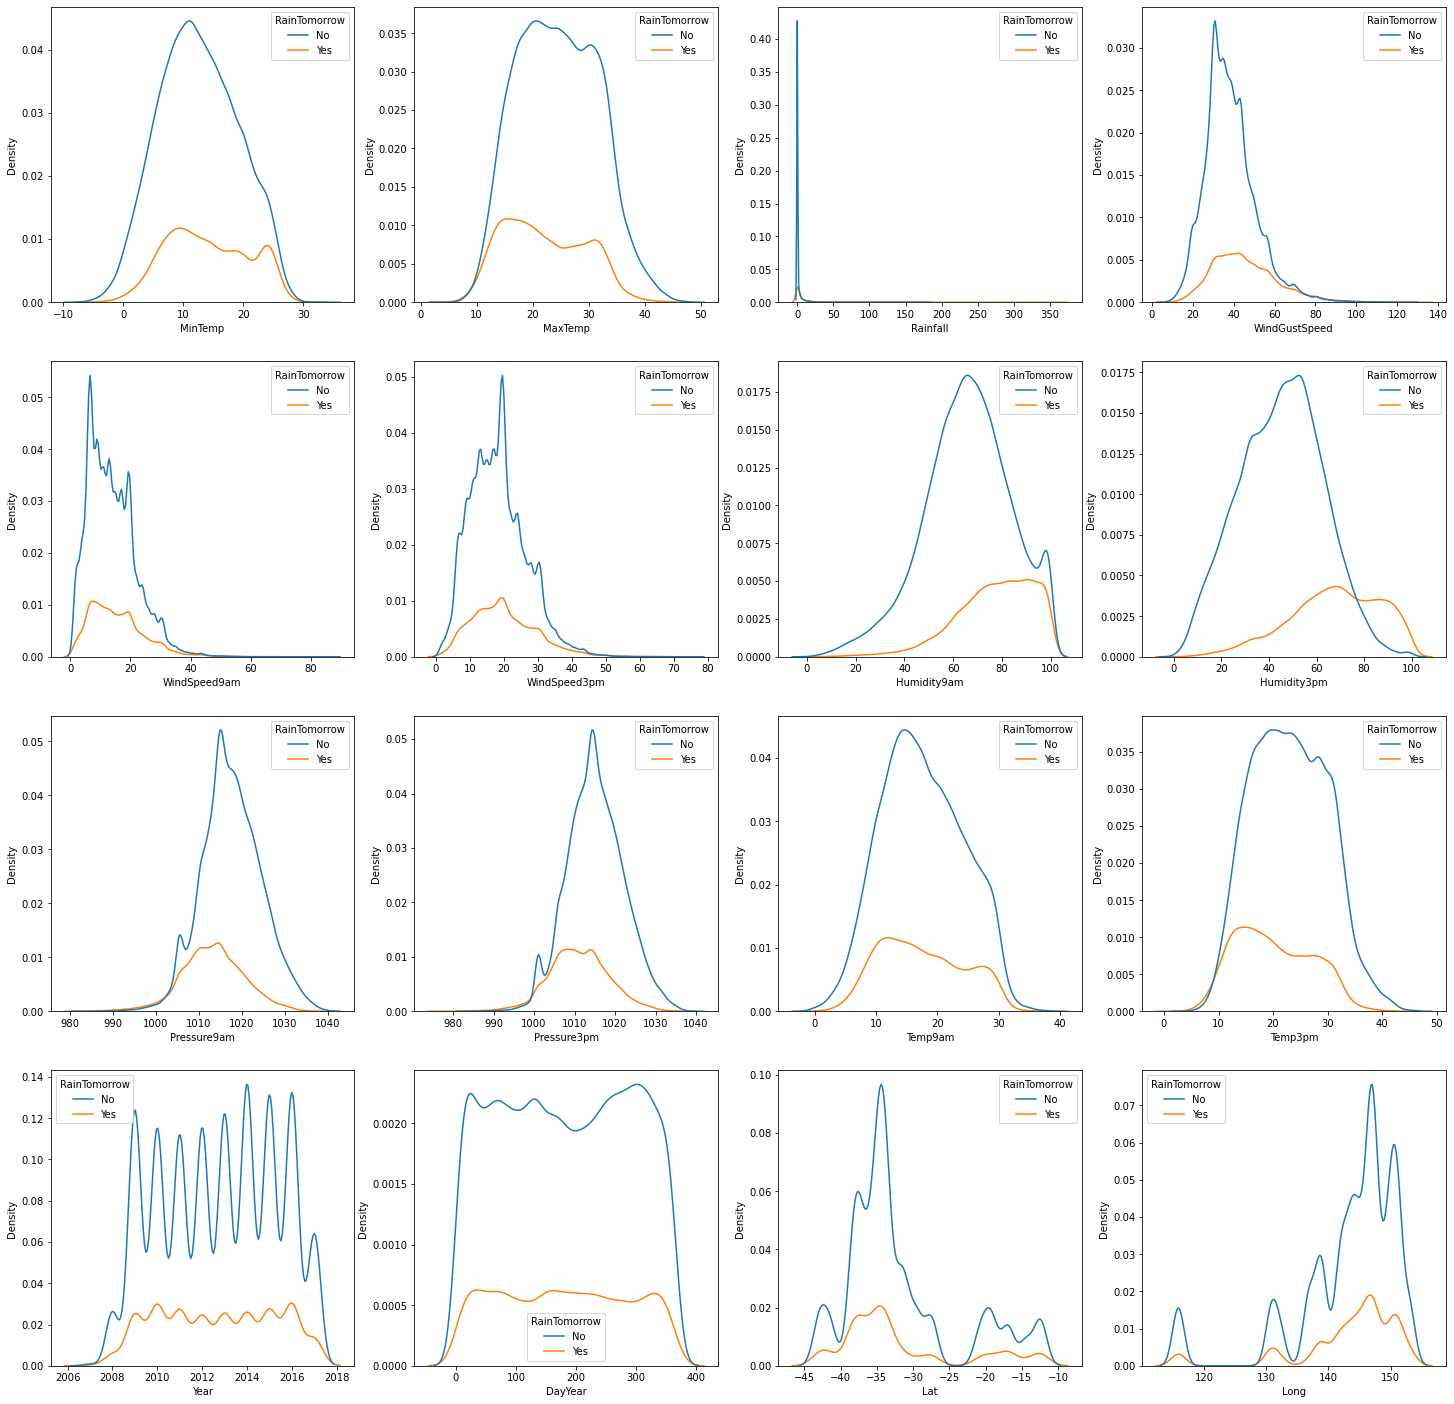

In [28]:
fig, axes = plt.subplots(4,4,figsize=(25, 25))
for i,col in enumerate(float_cols):
    plt_col = i%4
    plt_row = floor(i/4)
    sns.kdeplot(ax = axes[plt_row,plt_col], data = full_data, x = col, hue = "RainTomorrow")

In [29]:
full_data.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year,DayYear,Lat,Long
count,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.00000,66418.000000,66418.000000,66418.000000,66418.000000
mean,12.913385,23.962423,2.399419,39.826207,14.137252,18.652368,68.260080,49.993285,1016.733648,1014.274959,17.563615,22.43866,2012.739815,181.570945,-31.698210,143.457852
std,6.646052,7.230267,8.970350,13.384859,8.160001,8.479183,17.960279,20.045970,7.184667,7.204907,6.692555,7.03850,2.564801,106.697702,8.056043,8.203915
min,-7.600000,4.100000,0.000000,7.000000,2.000000,2.000000,0.000000,0.000000,982.000000,977.100000,-1.400000,1.70000,2007.000000,1.000000,-42.880600,115.858900
25%,8.000000,18.100000,0.000000,31.000000,7.000000,13.000000,57.000000,35.000000,1012.100000,1009.500000,12.500000,16.80000,2011.000000,88.000000,-36.750000,141.600000
50%,12.500000,23.700000,0.000000,37.000000,13.000000,19.000000,69.000000,50.000000,1016.500000,1014.200000,17.100000,22.20000,2013.000000,181.000000,-34.188900,145.770300
75%,17.900000,29.700000,0.600000,46.000000,19.000000,24.000000,81.000000,63.000000,1021.500000,1019.000000,22.600000,27.90000,2015.000000,275.000000,-29.465000,149.126900
max,33.900000,48.100000,367.600000,130.000000,87.000000,76.000000,100.000000,100.000000,1040.500000,1039.600000,39.000000,46.70000,2017.000000,366.000000,-12.438100,153.028100


Except "Rainfall" and (of course) "Lat" & "Long", all the columns seem quite normally distributed. We will check the skewness of all of them:

#### Checking skewness of float features

In [30]:
def check_skew(df, skew_limit=0.75):
    '''This function will populate a dataframe with the skewness of the distribution'''
    mask = df.dtypes == "float64"
    float_cols = df.columns[mask]
   
    skew_vals = df[float_cols].skew()

    skew_cols = (skew_vals
                 .sort_values(ascending=False)
                 .to_frame()
                 .rename(columns={0:'Skew'})
                 .query('abs(Skew) > {0}'.format(skew_limit)))

    return skew_cols

In [31]:
skew_cols = check_skew(full_data, skew_limit=0.75) # I am thresholding skewness at 0.75
skew_cols

,Skew
Rainfall,10.002627
Lat,1.076739
WindGustSpeed,0.993297
WindSpeed9am,0.944518
Long,-1.784132


Let us visualize what we get if we transform these columns by log1p or boxcox transform:

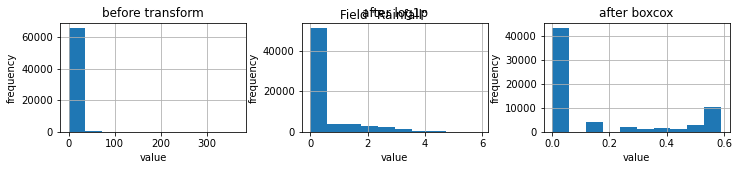

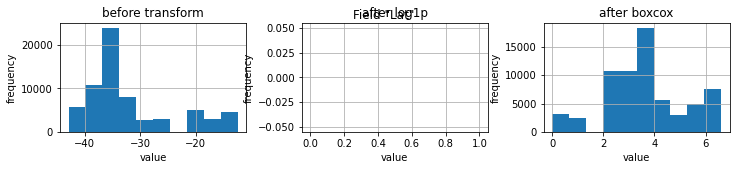

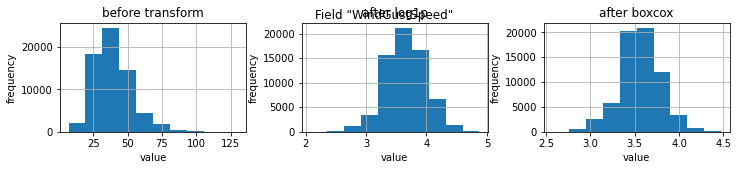

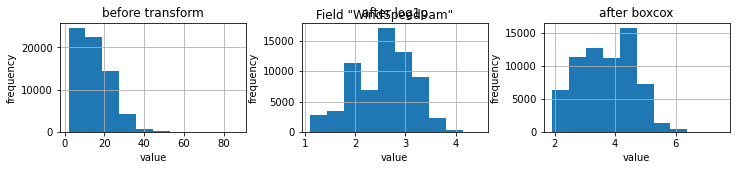

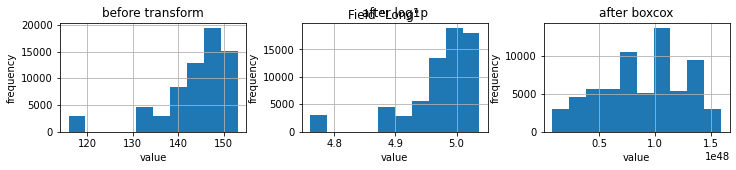

In [32]:
for field in skew_cols.index:
    
    fig, (ax_before, ax_log, ax_boxcox) = plt.subplots(1, 3, figsize=(12, 2))
    full_data[field].hist(ax=ax_before)
    
    full_data[field].apply(np.log1p).hist(ax=ax_log)
    data,lambda_ = boxcox(full_data[field]+ np.abs(min(full_data[field]))+1) # Boxcox is for positive values
    
    pd.DataFrame(data).hist(ax=ax_boxcox)
    
    ax_before.set(title='before transform', ylabel='frequency', xlabel='value')
    ax_log.set(title='after log1p', ylabel='frequency', xlabel='value')
    ax_boxcox.set(title='after boxcox', ylabel='frequency', xlabel='value')
    
    fig.suptitle('Field "{}"'.format(field));

From these graphs, I think we can simply apply a log1p transform for most of the features, except Lat & Long where we will use a Boxcox transform.

In [33]:
for field in ['Rainfall', 'WindGustSpeed', 'WindSpeed9am']:
    full_data[field] = full_data[field].apply(np.log1p)
    
for field in ['Lat', 'Long']:
    full_data[field], lambda_ = boxcox(full_data[field]+ np.abs(min(full_data[field]))+1)

And check again for skewness:

In [34]:
check_skew(full_data)

,Skew
Rainfall,2.107308


It is way better, I think we can continue.

#### Outliers
From a quick inspection, I think we can consider there are no outliers in this dataset: most of the float features are not skewed. The only remaining one is Rainfall, but we can have sudden strong rainfalls. I decided to keep the Rainfall feature as it is.

## 4.Strings conversions
Let us simply replace the direction strings by their equivalent in degrees and Yes/No by 1/0. This is exactly like doing Label encoding, but easier to interpret for a human reader.

In [35]:
angle_map = {'N':0, 'NNE':22.5, 'NE':45, 'ENE':67.5, 'E':90, 'ESE': 112.5, 'SE':135, 'SSE':157.5, 
                'S':180, 'SSW':202.5, 'SW':225, 'WSW':247.5, 'W':270, 'WNW':292.5, 'NW':315, 'NNW':337.5 }
bool_map = {'No':0, 'Yes':1}
full_data.replace({"WindGustDir": angle_map, 'WindDir9am':angle_map, 
                    'WindDir3pm':angle_map, 'RainToday':bool_map, 
                   'RainTomorrow':bool_map }, inplace = True)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66418 entries, 0 to 66417
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        66418 non-null  float64
 1   MaxTemp        66418 non-null  float64
 2   Rainfall       66418 non-null  float64
 3   WindGustDir    66418 non-null  float64
 4   WindGustSpeed  66418 non-null  float64
 5   WindDir9am     66418 non-null  float64
 6   WindDir3pm     66418 non-null  float64
 7   WindSpeed9am   66418 non-null  float64
 8   WindSpeed3pm   66418 non-null  float64
 9   Humidity9am    66418 non-null  float64
 10  Humidity3pm    66418 non-null  float64
 11  Pressure9am    66418 non-null  float64
 12  Pressure3pm    66418 non-null  float64
 13  Temp9am        66418 non-null  float64
 14  Temp3pm        66418 non-null  float64
 15  RainToday      66418 non-null  int64  
 16  RainTomorrow   66418 non-null  int64  
 17  Year           66418 non-null  float64
 18  DayYea

In [36]:
count_unique_strings(full_data)

There are no object features in the dataset.


Let's have a last look at our dataset:

In [37]:
full_data.head(10)

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,DayYear,Lat,Long
0,8.8,15.7,1.791759,315.0,3.891820,225.0,270.0,2.639057,15.0,92.0,...,1017.4,1017.7,13.5,14.9,1,0,2008.0,183.0,3.272281,5.205520e+47
1,12.7,15.8,0.587787,225.0,3.583519,202.5,225.0,2.639057,15.0,75.0,...,1022.4,1022.6,13.7,15.5,0,0,2008.0,184.0,3.272281,5.205520e+47
2,6.2,15.1,0.000000,270.0,3.044522,22.5,225.0,1.098612,11.0,81.0,...,1027.8,1026.5,9.3,13.9,0,0,2008.0,185.0,3.272281,5.205520e+47
3,5.3,15.9,0.000000,22.5,3.433987,22.5,45.0,1.945910,13.0,71.0,...,1028.7,1025.6,10.2,15.3,0,0,2008.0,186.0,3.272281,5.205520e+47
4,7.6,11.2,2.844909,247.5,3.850148,292.5,225.0,2.890372,13.0,83.0,...,1015.9,1017.9,9.8,9.3,1,1,2008.0,189.0,3.272281,5.205520e+47
5,5.3,13.5,2.890372,225.0,3.784190,225.0,247.5,2.484907,22.0,73.0,...,1025.8,1025.9,10.9,10.8,1,1,2008.0,190.0,3.272281,5.205520e+47
6,8.4,14.3,1.029619,315.0,3.737670,0.0,315.0,2.302585,19.0,90.0,...,1025.8,1022.7,10.8,13.5,1,1,2008.0,191.0,3.272281,5.205520e+47
7,9.5,13.1,2.302585,247.5,3.970292,247.5,225.0,3.218876,20.0,54.0,...,1019.8,1019.6,10.9,11.2,1,0,2008.0,192.0,3.272281,5.205520e+47
8,10.0,15.4,1.568616,0.0,3.891820,270.0,270.0,2.772589,19.0,85.0,...,1014.0,1015.4,13.2,15.2,1,1,2008.0,196.0,3.272281,5.205520e+47
9,11.1,14.7,1.609438,247.5,3.784190,270.0,247.5,2.890372,24.0,91.0,...,1020.4,1020.1,12.0,13.0,1,0,2008.0,197.0,3.272281,5.205520e+47


In [38]:
check_for_nans(full_data)

There are no NaN values in the dataset.


### Last thing: scaling of the data. 
As I assumed there were no outliers, I will use a Robust scaler which should be more resilient to outliers. Just in case I'm wrong... I'm afraid it happens.

In [39]:
from sklearn.preprocessing import RobustScaler

RS = RobustScaler()

mask = full_data.dtypes == "float64" # Conveniently, this will not select the Yes/No columns as they are int.

float_cols = full_data.columns[mask]

for col in float_cols:
    full_data[col] = RS.fit_transform(full_data[col].to_numpy().reshape(-1,1)) 
    # The conversion from 1D array to 2D array for SKLearn is annoying.
    
    

### Last description:
Our data are scaled, deskewed, without NaNs.

In [40]:
full_data.describe()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,DayYear,Lat,Long
count,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,...,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000,66418.000000
mean,0.041756,0.022623,1.015224,0.077637,0.051889,0.018799,-0.043851,-0.085072,-0.031603,-0.030830,...,0.024856,0.007890,0.045903,0.021501,0.217531,0.213466,-0.065046,0.003053,0.114990,-0.063886
std,0.671318,0.623299,1.930963,0.566399,0.842636,0.571089,0.577293,0.640578,0.770835,0.748345,...,0.764326,0.758411,0.662629,0.634099,0.412570,0.409757,0.641200,0.570576,0.998953,0.727545
min,-2.030303,-1.689655,0.000000,-0.875000,-4.053323,-0.875000,-1.000000,-1.681175,-1.545455,-2.875000,...,-3.670213,-3.905263,-1.831683,-1.846847,0.000000,0.000000,-1.500000,-0.962567,-2.198970,-1.595543
25%,-0.454545,-0.482759,0.000000,-0.375000,-0.447047,-0.500000,-0.500000,-0.610740,-0.545455,-0.500000,...,-0.468085,-0.494737,-0.455446,-0.486486,0.000000,0.000000,-0.500000,-0.497326,-0.406359,-0.485190
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.545455,0.517241,1.000000,0.625000,0.552953,0.500000,0.500000,0.389260,0.454545,0.500000,...,0.531915,0.505263,0.544554,0.513514,0.000000,0.000000,0.500000,0.502674,0.593641,0.514810
max,2.161616,2.103448,12.573758,1.000000,3.219494,1.000000,0.875000,2.006219,5.181818,1.291667,...,2.553191,2.673684,2.168317,2.207207,1.000000,1.000000,1.000000,0.989305,2.024547,1.294560


The dataset seems ok to be used now. I still need to balance the set but I will do it later.
We can save it as a new csv file:

In [41]:
full_data.to_csv('C:/Users/Syla/CourseRA/WeatherForML.csv')

## 5. Classifications

First, reopen the file (as it was made on different days, I start from here after the EDA) and separate the dataset into train & test sets:

In [42]:
ml_data = pd.read_csv('C:/Users/Syla/CourseRA/WeatherForML.csv')

Let us check the balance of the dataset:

In [43]:
ml_data['RainTomorrow'].value_counts(normalize=True)

0    0.786534
1    0.213466
Name: RainTomorrow, dtype: float64

It is quite unbalanced toward 0 (No, it will not rain tomorrow), so we will use a stratified shuffle split and an upsampler:

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

target_col = 'RainTomorrow'
feature_cols = ml_data.columns[ml_data.columns != target_col]

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(ml_data[feature_cols], ml_data[target_col]))


# Create the dataframes
X_train = ml_data.loc[train_idx, feature_cols]
y_train = ml_data.loc[train_idx, target_col]

X_test  = ml_data.loc[test_idx, feature_cols]
y_test  = ml_data.loc[test_idx, target_col]

I will use SMOTE to upsample my train sets:

In [45]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# All of this comes directly from imblearn documentation...

# We upsample only the train dataset.
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

print('Before SMOTE: ' + str(sorted(Counter(y_train).items())))
print('After SMOTE: ' + str(sorted(Counter(y_resampled).items())))

Before SMOTE: [(0, 36568), (1, 9924)]
After SMOTE: [(0, 36568), (1, 36568)]


We can see the effect of SMOTE with the before/after: we upsampled the number of '1' to reach the same number of '0'.

#### 5.1 Let's start with a really simple logistic regression:

In [46]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import time

begin = time.time() # I will calculate the time spent on every steps as well.

LogReg_model = LogisticRegression(solver='liblinear').fit(X_resampled, y_resampled)

inter = time.time() # This will give the fitting time

y_pred_lr = LogReg_model.predict(X_test)
y_pred_proba_lr = LogReg_model.predict_proba(X_test)

end = time.time() # And this the prediction time

In [47]:
# Many imports for analyze & metrics:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, make_scorer
from sklearn.preprocessing import label_binarize

In [48]:
def get_metrics(test, prediction, name='None', fit_time=0, pred_time=0):
    '''This function will return all possible metrics in a nice Dataframe and the confusion matrix as well.'''
    
    metrics = list()
    cm = dict()

    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, support = score(test, prediction, average='weighted')

    # The usual way to calculate accuracy
    accuracy = accuracy_score(test, prediction)

    # ROC-AUC scores can be calculated by binarizing the data. 
    # I will use this function only with 0/1, so hardcoding the classes.
    auc = roc_auc_score(label_binarize(test, classes=[0,1]),
                        label_binarize(prediction, classes=[0,1]),
                        average='weighted')

    # Last, the confusion matrix
    cm = confusion_matrix(test, prediction)

    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc': auc, 
                              'Fit duration (s)': fit_time,
                              'Pred duration (s)': pred_time},
                              name=name))

    metrics = pd.DataFrame(metrics)
    
    return metrics, cm
               

In [49]:
metrics_lr, cm_lr = get_metrics(y_test, y_pred_lr,
                                name = 'Logistic Regression',
                                fit_time = inter - begin, 
                                pred_time = end - inter)

metrics_lr

,precision,recall,fscore,accuracy,auc,Fit duration (s),Pred duration (s)
Logistic Regression,0.835749,0.806584,0.816305,0.806584,0.777023,0.601828,0.015978


We obtain 0.8 Accuracy and 0.7 Area under the Curve for a simple logistic regression. Not bad, I guess. Let's plot the ROC and confusion matrix:

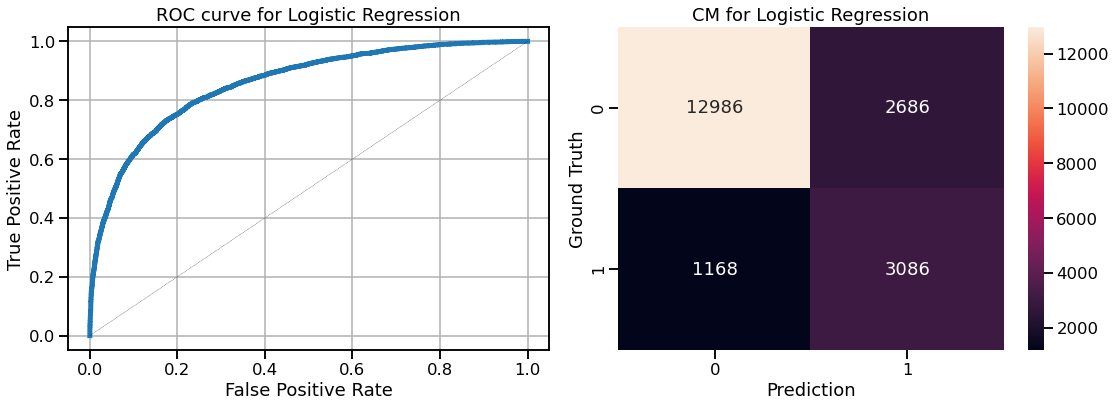

In [50]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 6)

# ROC Curve to the left
ax = axList[0]   

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr[:,1])
ax.plot(fpr, tpr, linewidth=5)
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       title='ROC curve for Logistic Regression')
ax.grid(True)    


# Confusion Matrix to the right
ax = axList[1]

ax = sns.heatmap(cm_lr, annot=True, fmt='d');
ax.set(title='CM for Logistic Regression',
       xlabel = 'Prediction',
       ylabel = 'Ground Truth');

plt.tight_layout()




This is a first start. Now let's use some regularization to this logistic regression. We should be able to improve these scores

In [51]:
Cs_values = [1, 10, 100]

metrics_reg = pd.DataFrame()

# We have to define another way to score the fit than the default "Accuracy", as classes are unbalanced.
roc_auc_weighted = make_scorer(roc_auc_score, average='weighted') 


for value in Cs_values:
    begin = time.time()
    LogRegCV_model = LogisticRegressionCV(Cs = value, cv = 4, 
                                          penalty = 'l2',
                                          scoring = roc_auc_weighted, # Here is the scoring method
                                          solver = 'liblinear').fit(X_resampled, y_resampled)

    inter = time.time() # This will give the fitting time

    y_pred_lrreg = LogRegCV_model.predict(X_test)
    y_pred_proba_lrreg = LogRegCV_model.predict_proba(X_test)

    end = time.time() # And this the prediction time
    
    metrics_lrreg, cm_lrreg = get_metrics(y_test, y_pred_lrreg,
                                name = 'LogRegCV, Cs=' + str(value),
                                fit_time = inter - begin, 
                                pred_time = end - inter)
    
    metrics_reg = pd.concat([metrics_reg, metrics_lrreg])

metrics_reg

,precision,recall,fscore,accuracy,auc,Fit duration (s),Pred duration (s)
"LogRegCV, Cs=1",0.824260,0.777677,0.791957,0.777677,0.761472,1.854797,0.007988
"LogRegCV, Cs=10",0.836174,0.805731,0.815755,0.805731,0.778108,15.563550,0.007996
"LogRegCV, Cs=100",0.835798,0.806685,0.816390,0.806685,0.777087,147.408809,0.007982


This is not really better: we reach the same scores than a standard logistic regression with Cs = 10, but at a great computation cost. It takes 16s instead of 0.7s.

Let's try with another estimator.

#### 5.2 K-Nearest Neighbors

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
metrics_knn = pd.DataFrame()

for k in [1, 5, 11, 15, 21]:
    # I use only these 5 values for an elbow-method, as too many makes my computer wish to die...
    # The rest is basically the same than before.
    
    knn = KNeighborsClassifier(n_neighbors=k)

    begin = time.time()
    knn = knn.fit(X_resampled, y_resampled)

    inter = time.time()
    y_pred_knn = knn.predict(X_test)

    end=time.time()

    metrics, cm = get_metrics(y_test, y_pred_knn,
                              name = 'K-NN, k=' + str(k),
                              fit_time = inter - begin,
                              pred_time = end - inter)
    
    metrics_knn = pd.concat([metrics_knn, metrics])
    
metrics_knn
    


,precision,recall,fscore,accuracy,auc,Fit duration (s),Pred duration (s)
"K-NN, k=1",0.759945,0.732159,0.743478,0.732159,0.653154,0.013963,18.523441
"K-NN, k=5",0.763664,0.693767,0.716539,0.693767,0.662744,0.010973,29.103233
"K-NN, k=11",0.754020,0.666867,0.693888,0.666867,0.646157,0.009973,29.324904
"K-NN, k=15",0.753084,0.658035,0.686614,0.658035,0.643967,0.010972,28.604139
"K-NN, k=21",0.751915,0.644434,0.675221,0.644434,0.640716,0.011011,28.449215


K-NN performs worst than logistic regressions. And we can clearly see that the fit is unexpensive, but the prediction takes time with this algorithm.

Let's try another estimator:

#### 5.3 Boosting

Structure is the same but with a GradientBoosting Classifier.

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
metrics_boost = pd.DataFrame()
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    begin = time.time()
    GBC.fit(X_resampled, y_resampled)
    
    inter = time.time()
    y_pred_boost = GBC.predict(X_test)
    
    end = time.time()
    # Get the error
    metrics, cm = get_metrics(y_test, y_pred_boost,
                              name = 'Boost, trees=' + str(n_trees),
                              fit_time = inter - begin,
                              pred_time = end - inter)
    
    metrics_boost = pd.concat([metrics_boost, metrics])
    
metrics_boost

,precision,recall,fscore,accuracy,auc,Fit duration (s),Pred duration (s)
"Boost, trees=15",0.825605,0.796447,0.806494,0.796447,0.760388,4.687515,0.012965
"Boost, trees=25",0.830745,0.809445,0.817199,0.809445,0.765826,7.636426,0.015975
"Boost, trees=50",0.837318,0.822694,0.828326,0.822694,0.772793,15.368122,0.023939
"Boost, trees=100",0.842852,0.839305,0.840928,0.839305,0.771279,30.801398,0.035949
"Boost, trees=200",0.850375,0.854913,0.852170,0.854913,0.766386,61.295619,0.059913
"Boost, trees=400",0.856896,0.863545,0.858475,0.863545,0.764338,121.956139,0.151797


We can see that the precision increases with the number of trees, but the auc stays more or less constant. Maybe a small  improvement for n_trees = 50.

#### Conclusion from all these models:

Let's concatenate all the results we got to better compare them:

In [56]:
all_metrics = pd.concat([metrics_lr, metrics_reg, metrics_knn, metrics_boost])

cm = sns.light_palette("green", as_cmap=True)
colored_metrics = all_metrics.style.background_gradient(subset=['auc', 'precision'], low=.76, high=0.78, cmap=cm)

colored_metrics

,precision,recall,fscore,accuracy,auc,Fit duration (s),Pred duration (s)
Logistic Regression,0.835749,0.806584,0.816305,0.806584,0.777023,0.601828,0.015978
"LogRegCV, Cs=1",0.824260,0.777677,0.791957,0.777677,0.761472,1.854797,0.007988
"LogRegCV, Cs=10",0.836174,0.805731,0.815755,0.805731,0.778108,15.563550,0.007996
"LogRegCV, Cs=100",0.835798,0.806685,0.816390,0.806685,0.777087,147.408809,0.007982
"K-NN, k=1",0.759945,0.732159,0.743478,0.732159,0.653154,0.013963,18.523441
"K-NN, k=5",0.763664,0.693767,0.716539,0.693767,0.662744,0.010973,29.103233
"K-NN, k=11",0.754020,0.666867,0.693888,0.666867,0.646157,0.009973,29.324904
"K-NN, k=15",0.753084,0.658035,0.686614,0.658035,0.643967,0.010972,28.604139
"K-NN, k=21",0.751915,0.644434,0.675221,0.644434,0.640716,0.011011,28.449215
"Boost, trees=15",0.825605,0.796447,0.806494,0.796447,0.760388,4.687515,0.012965


From these results, we can see that the simple logistic Regression might be the best choice for this task. The auc for this estimator is high, we can get a better precision with Boost but it is so slow compared to a logistic regression that it may not be worth using it.
Now, all estimators have similar results except K-NN, which is clearly behind.

#### Now, let's plot all the best conditions we found:

We can simply iterate through all our models, with the optimal settings we found already. And plot the ROC curves and Confusion Matrixes.

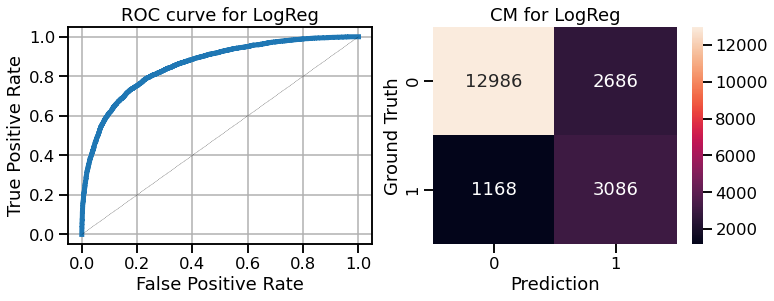

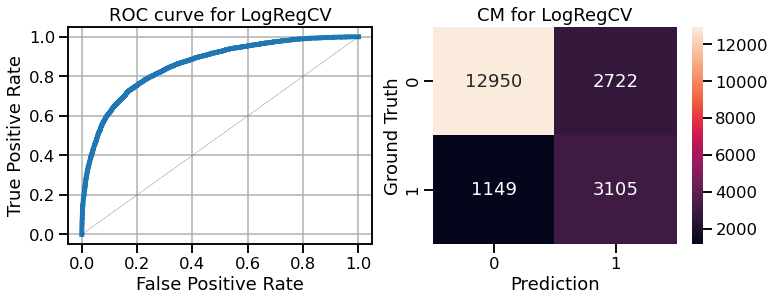

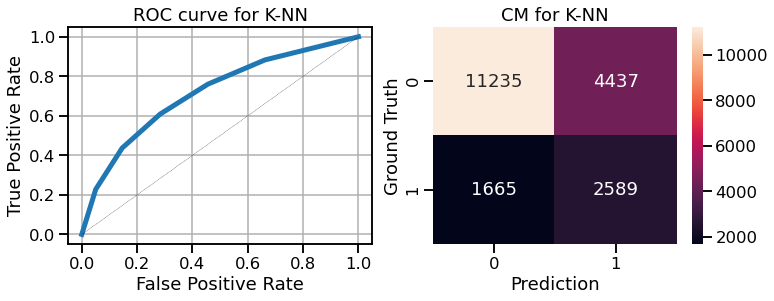

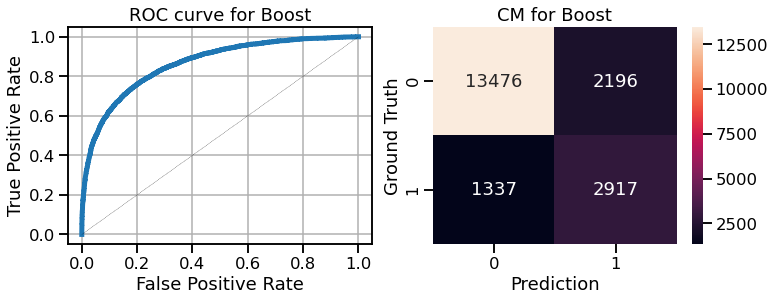

,precision,recall,fscore,accuracy,auc,Fit duration (s),Pred duration (s)
LogReg,0.835749,0.806584,0.816305,0.806584,0.777023,0.543192,0.006380
LogRegCV,0.836174,0.805731,0.815755,0.805731,0.778108,15.825194,0.007995
K-NN,0.763664,0.693767,0.716539,0.693767,0.662744,0.011986,57.749007
Boost,0.837318,0.822694,0.828326,0.822694,0.772793,16.066688,0.050826


In [60]:
names = ["LogReg", "LogRegCV", "K-NN", "Boost"]

roc_auc_weighted = make_scorer(roc_auc_score, average='weighted') 

classifiers = [LogisticRegression(solver='liblinear'),
               LogisticRegressionCV(Cs = 10, cv = 4, penalty = 'l2',
                                    scoring = roc_auc_weighted,
                                    solver = 'liblinear'),
               KNeighborsClassifier(n_neighbors=5),
               GradientBoostingClassifier(n_estimators=50, random_state=42)]

new_metrics = pd.DataFrame()
new_cm = pd.DataFrame()
new_proba = pd.DataFrame()

sns.set_context('talk')

for name, estimator in zip(names, classifiers):
    
    begin = time.time()
    estimator.fit(X_resampled, y_resampled)
        
    inter = time.time()
    y_pred = estimator.predict(X_test)
    y_pred_proba = estimator.predict_proba(X_test)
    
    end = time.time()
    
    metrics, cm = get_metrics(y_test, y_pred,
                              name = name,
                              fit_time = inter - begin,
                              pred_time = end - inter)
    
    # Saving informations here
    new_metrics = pd.concat([new_metrics, metrics])
    new_cm = pd.concat([new_cm, pd.DataFrame(cm)])
    new_proba = pd.concat([new_proba, pd.DataFrame(y_pred_proba)])
    
    # And then showing the curves
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(12, 4)

    # ROC Curve to the left
    ax = axList[0]   

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    ax.plot(fpr, tpr, linewidth=5)
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           title='ROC curve for ' + name)
    ax.grid(True)    


    # Confusion Matrix to the right
    ax = axList[1]

    ax = sns.heatmap(cm, annot=True, fmt='d');
    ax.set(title='CM for ' + name,
           xlabel = 'Prediction',
           ylabel = 'Ground Truth');

    plt.show()
    
new_metrics
    

With these parameters, we can see that LogRegCV might be just a bit better than LogReg, but with a great computation cost.

#### Models improvements
Importantly, everything I did could have been simplified in a single loop with Pipeline and GridSearchCV. For example, this piece of code does exactly the same:

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

names = ["LogReg", "LogRegCV", "K-NN", "Boost"]

# We will use auc score as the classes are unbalanced
roc_auc_weighted = make_scorer(roc_auc_score, average='weighted') 

# Add as many classifiers you wish here.
classifiers = [LogisticRegression(),
               LogisticRegressionCV(),
               KNeighborsClassifier(),
               GradientBoostingClassifier()]

# Many parameters can be changed here, I used the same than before for simplification. 
# Array has to match the classifiers one. Use __ to pass the parameter.
parameters = [{'clf__solver': ['liblinear']},
              {'clf__Cs': [1, 10], 'clf__cv': [4], 'clf__penalty': ['l1','l2'], 'clf__solver': ['liblinear']},
              {'clf__n_neighbors': np.arange(1, 10)},
              {'clf__n_estimators': [15, 25, 50, 100, 200, 400], 'clf__random_state': [42]}]

for name, classifier, params in zip(names, classifiers, parameters):
    
    clf_pipe = Pipeline([('clf', classifier)]) # Single step, as I scaled my data already
        
    gs_clf = GridSearchCV(clf_pipe, param_grid=params, scoring = roc_auc_weighted)
    clf = gs_clf.fit(X_resampled, y_resampled)
    score2 = clf.score(X_test, y_test)
    
    print("{} auc score: {}".format(name, score2)) # Using print to be quicker.
    
    print('Best params are:')
    print(clf.best_estimator_)
    print('<--------------->')

LogReg auc score: 0.7770232106562529
Best params are:
Pipeline(steps=[('clf', LogisticRegression(solver='liblinear'))])
<--------------->
LogRegCV auc score: 0.7761366475368467
Best params are:
Pipeline(steps=[('clf',
                 LogisticRegressionCV(cv=4, penalty='l1', solver='liblinear'))])
<--------------->
K-NN auc score: 0.6531541613658274
Best params are:
Pipeline(steps=[('clf', KNeighborsClassifier(n_neighbors=1))])
<--------------->
Boost auc score: 0.7643381852662227
Best params are:
Pipeline(steps=[('clf',
                 GradientBoostingClassifier(n_estimators=400,
                                            random_state=42))])
<--------------->


And we have access to the different attributes, timings, etc... with cv_results_. For example, here we have access to the results of the GradientBoostClassifier (the last one used in the loop):

In [66]:
clf.cv_results_

{'mean_fit_time': array([ 3.68675003,  6.18267436, 12.2876627 , 24.83267994, 49.95661902,
        98.85613327]),
 'std_fit_time': array([0.21409361, 0.2115567 , 0.58127585, 1.02617191, 2.24174796,
        5.6044726 ]),
 'mean_score_time': array([0.01257844, 0.01576667, 0.02094226, 0.03072958, 0.04709105,
        0.08282909]),
 'std_score_time': array([0.00080492, 0.00223939, 0.00124592, 0.00075613, 0.00100591,
        0.00176602]),
 'param_clf__n_estimators': masked_array(data=[15, 25, 50, 100, 200, 400],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__random_state': masked_array(data=[42, 42, 42, 42, 42, 42],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__n_estimators': 15, 'clf__random_state': 42},
  {'clf__n_estimators': 25, 'clf__random_state': 42},
  {'clf__n_estimators': 50, 'clf__random_state': 42},
  {'clf__n_esti

We could improve our pipeline by adding the scaling, the upsampling, etc... but I did it first and independently to speed things. This pipeline method is superior but I did not use it in the end, for 2 reasons: i) I built the estimators progressively, trying things and increasing the general complexity. And ii) it is wayyyyy too long to compute: this simple pipeline takes more than 20 minutes to execute, using n_jobs=-1 decreases the duration but almost freezes my computer for the time. Using small independent models kept things manageable in term of computation time.

## Conclusion

I cleaned our dataset and did some feature engineering. I removed many NaNs, replaced some others by interpolation, changed the categorical locations by the latitude & longitude, scaled everything with a RobustScaler and upsampled the dataset as it was unbalanced. I tried 4 different classifier to answer the question "Will it rain Tomorrow?": A standard logistic regression, a logistic regression with regularization, a K-NN algorithm and a boosting algorithm. The K-NN performed quite badly, the others are comparable. If we take the computation time into account, the simple logistic regression might be the best choice: it is really quick and differences with others are minimal.

### Things to improve:

* I must admit I am a bit disappointed with the overall performances of the estimators. We obtain a 0.77 auc, I was hoping for better. When checking on Kaggle, some people show better scores but: i) They almost only show the accuracy score, which is a bit unproper with an unbalanced dataset. ii) They mostly do not upsample their dataset. I did some tries without SMOTE, it increases the accuracy but decreases the auc (as expected with an unbalanced dataset). and iii) The best scores are obtained with different estimators, such as XGBoost and NN. They simply might be better.

* I removed many NaNs by dropping 4 columns. Some people keep them and simply replace all the NaNs by the mode of the population. I am quite reluctant to do that as it represents 40% of the whole population, but I might be wrong.

* As said before, the pipeline could be improved to do all of this in one shot. But I will do it with a smaller dataset or a bigger computer. Or might be time to learn Apache Spark...